In [2]:
from dask.distributed import Client

client = Client("tcp://127.0.0.1:38150")
client

Client Scheduler: tcp://127.0.0.1:38150 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 4 Memory: 2.15 GB


go to the dask array tab (shown below) and click on '<>'

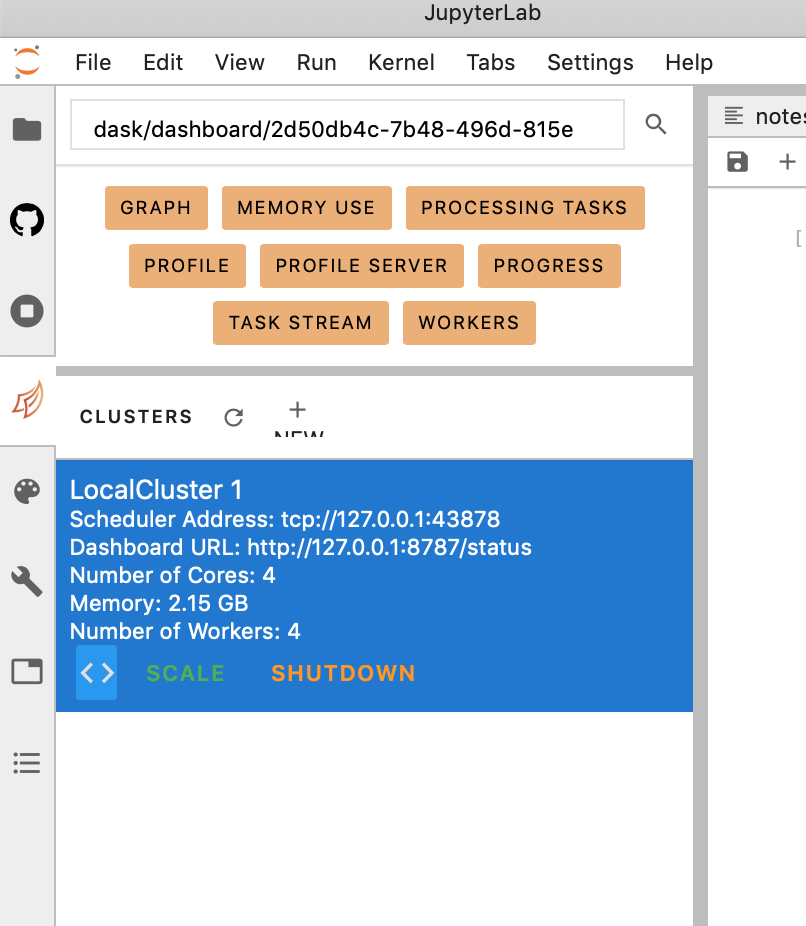

In [4]:
from IPython.display import Image
Image(filename='./images/dask.png',width=400)

something similar to the cell below should have being incerted

# imports

In [21]:
from negi_stuff.modules.imps import (
    pd, np, xr, za, mpl, plt, sns, pjoin, os,
    glob, dt, sys, ucp, log, crt, cmip6
)

In [22]:
from pathlib import Path

## select a large dataset 

In [23]:
df = cmip6.search_cmip6_hist(wildcard='mmrso4*',model='CESM*')

In [24]:
_ds = df.sort_values(['FORCING','REALIZATION'],ascending=[False,True])

In [25]:
_ds = df.sort_values(
    by       = [cmip6.FF,cmip6.RR,cmip6.FF],
    ascending= [False   ,True    ,True]
              )

In [26]:
_dg = _ds.groupby(cmip6.MODEL).first()

In [27]:
SIZE = 'SIZE'
df[SIZE] = df[cmip6.FILES].apply(lambda f: os.path.getsize(f))

In [28]:
_r = df.sort_values(SIZE, ascending=False).iloc[20]

In [29]:
_r['FILE_PATH']

'/home/28f6ea40-2d3059-2d4f6b-2d8429-2deb8e956423db/shared-cmip6-for-ns1000k/historical/CESM2/r11i1p1f1/mmrso4_AERmon_CESM2_historical_r11i1p1f1_gn_185001-189912.nc'

In [30]:
large_file = '/home/28f6ea40-2d3059-2d4f6b-2d8429-2deb8e956423db/shared-cmip6-for-ns1000k/historical/CESM2/r11i1p1f1/mmrso4_AERmon_CESM2_historical_r11i1p1f1_gn_185001-189912.nc'

## open the xarray dataset

lets explore the dataset. 
however this is not opening the dataset as a 
[dask array] (https://examples.dask.org/xarray.html)

In [31]:
ds = xr.open_dataset(large_file)

/opt/conda/lib/python3.7/site-packages/xarray/conventions.py:494: SerializationWarning: variable 'mmrso4' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  use_cftime=use_cftime,


In [32]:
#lets check the dimensions
ds.dims

Frozen(SortedKeysDict({'time': 600, 'lev': 32, 'lat': 192, 'lon': 288, 'nbnd': 2}))

In [33]:
#this will load the dataset as a dask array and therefore it will not kill the kernel
#some understanding of which operations you will perform on the dataset are needed
#in this case we are slicing the dataset along time in chunks of 1.
ds = xr.open_dataset(large_file,chunks={'time':1})

In [34]:
var = 'mmrso4'

In [35]:
# this will run fast but its just bc it hasn't been evaluated yet. 
# so, daks will store the operations that you want on the dataset and only compute them 
# when its necessary (e.g. when you want to plot the results). You can force the computation by 
# calling .load() (see the next cell)
ds[var].mean()

<xarray.DataArray 'mmrso4' ()>
dask.array<mean_agg-aggregate, shape=(), dtype=float32, chunksize=(), chunktype=numpy.ndarray>

In [39]:
# in order to get the actual value you need to load
# this will take some time since now we are actually computing the mean.

In [38]:
ds[var][{'time':slice(0,None)}].mean().load()

<xarray.DataArray 'mmrso4' ()>
array(7.359101e-11, dtype=float32)

In [40]:
#convert cftime to datetime64
_c1 = ds['time'][0].item()
ds['time'] = pd.to_datetime(ds['time'].dt.strftime(_c1.format))

- first we average along the time dimension. 
- then we load the results
- finally we copy the attrs for aesthaetics

In [44]:
da1 = ds[var].groupby('time').mean(xr.ALL_DIMS).load()
da1 = da1.assign_attrs(ds[var].attrs)

- we do a rolling mean.
- we use the results from the previous loading

In [45]:
da_rolling_mean = da1.rolling({'time':12*10},min_periods=1,center=True).mean()
da_rolling_mean = da_rolling_mean.assign_attrs(ds[var].attrs)

- define a function for plotting

In [46]:
def _plot():
    ax = plt.axes()
    l1 = 'monthly'
    l2 = f'rolling mean [decade]'
    da1.            plot(marker='.',linestyle='None', alpha=.2, label =l1, ax=ax )
    da_rolling_mean.plot(marker='.',linestyle='-'   , alpha=1 , label =l2, ax=ax )

    ax.legend();

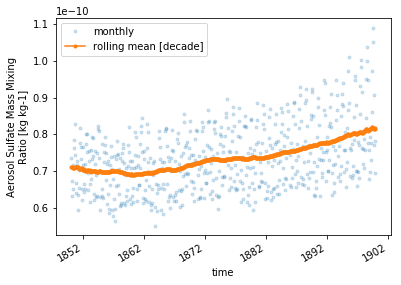

In [47]:
_plot()

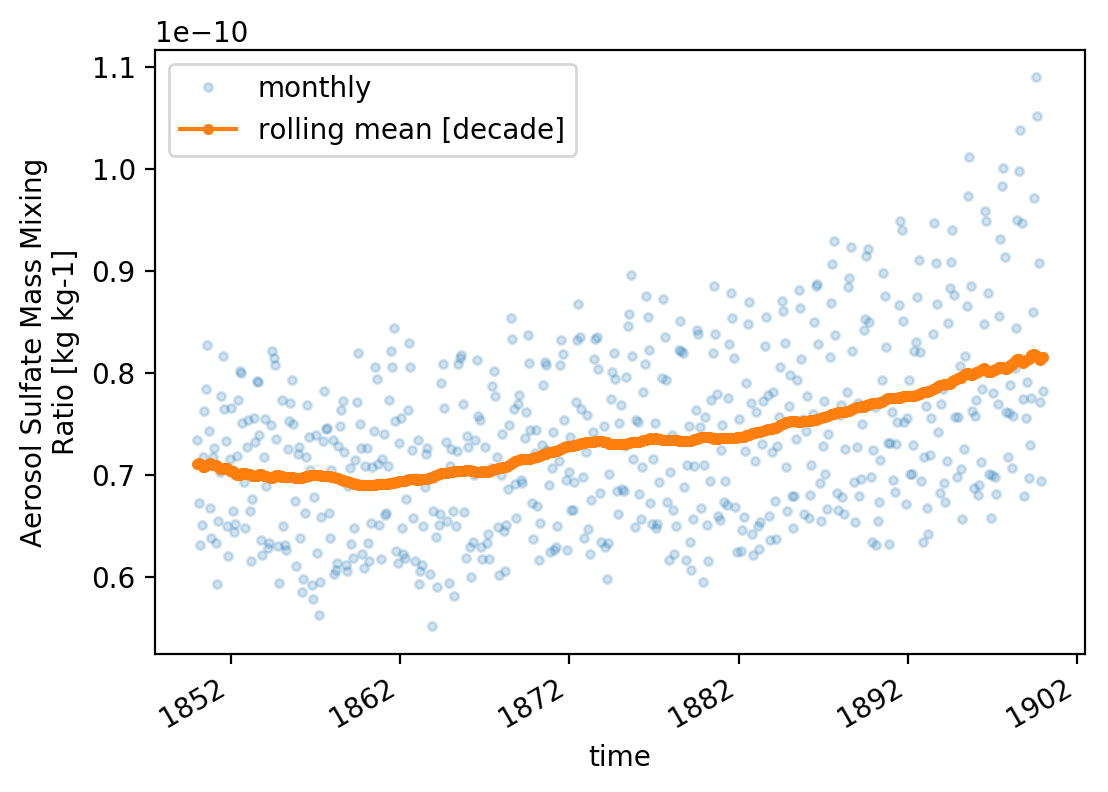

In [76]:
# increace res
mpl.rcParams['figure.dpi'] = 200
_plot()